In [123]:
import math
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline


# Getting an Intuitive Sense of Derivatives

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3)

xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
h = 0.00001
x = 3.0
(f(x + h) - f(x))/ h # converging on 14 as h gets smaller

In [ ]:
# an example with multiple inputs
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

# if I nudge one of the inputs (in this case 'a'), how does it impact the slope
d1 = a*b + c
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)



Adjusting `a` and finding the slope, we get back `b`. Adjusting `b` and finding the slope we get `a`. 

In [127]:
from graphviz import Digraph

# Graph Visualization Methods

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad, ), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2, in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [128]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # 0 means no effect
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"(Value(data={self.data}))"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __radd__(self, other): # re-ordering to self + other
        return self + other

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __rsub__(self, other):
        return self + (-other)
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self)
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
    
        def _backward():
            self.grad += other * self.data**(other -1) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self /other
        return self * other**-1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        # The derivative of e^x is... e^x! which we calculated for out already
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [ ]:
# Value class operator tests - just testing that it doesn't throw
# mult
a = Value(2.0)
2 * a
a * 2
# add
b = Value(2.0)
3 + b
b + 3
# subtract
a = Value(5.0)
b = Value(3.0)
a - b 
a - 4

# divide -
a = Value(2.0)
b = Value(4.0)
a / b

# Backpropogation: Calculating a nodes impact on the overall Loss Function

To calculate grad relative to a specific node (in this case 'L' the representation of the loss function), we walk back the dependency graph.

Starting with L (the final result of our loss function)

## Manual Back Propogation
`dL / dL = 1.00`

why: any amount you add ('h') is directly added to the total of the function

L = d * f
dL / dd = f

why is dL/dd = f

The basic form of a deravitive
(f(x + h) - f(x)) / h

Replacements for each term using `L = d * f`
```
f(x+h) = (d + h) * f
f(x) = d * f
```

Multiply out and simplify and you get `f`
```
((d+h) * f - d * f) / h
(d*f + h*f - d*f) / h
(h * f)/h
f
```

## Chain Rule

How do we calculate `dL / dc`?

First, what is the derivative of `dd / dc`

c + e = d
standard derivative form: 

```
(c + h + e - (c + e)) / h
h / h
```

What does dd/dc tell us? It is a local derivative that only tells us the grad between node `c` and node `d`

To get `dL / dc`, we have to walk back nodes multiplying local derivatives

```
dL / dc = (dL/dd) * (dd/dc)
dL / dc = 4 * 1 = 4
```


A practical example of the chain rule: if a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then car travels 2 * 4 = 8 times faster as the man

## What Back Propogation Gets us
Through recursive application of the chain rule through the graph, we get a grad indicating the influence of that node relative to the final output of the loss function.

## How to use this in the context of a loss function

Each leaf can now be nudged towards the goal of the function through repeated runs.

On our first forward pass of the function we get `-8`.

If our goal is `-6`, we can trying nudging our leafs. If we bump the grad of `a`, `b`, `c`, and `f` by `0.01` it becomes `-7.286`.

`0.01` is our guess nudge. On a first try we got closer to `-6`, and can now do an additional run to improve the guess.

# A more complex example: a neural net
![mathmatical representation of a neuron](./neuron_model.jpeg)

Image grabbed from Stanford's [CS231 page](https://cs231n.github.io/convolutional-networks/)

- w0x0 -> wnxn inputs to a cell body. `x` is some input. `w` is the weight
- in the cell body, those inputs are summed
- `b` some bias within the cell body
- `f`: an activation function, typically a 'squashing' function to get values within a specific range

In [ ]:
# activation function will be tanh
# It is a squashing function - x values coming in get sqaushed between -1 and 1
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# neuron value without activation function
n = x1w1x2w2 + b; n.label = 'n'
# now apply the activation function to squash into -1 to 1 range
o = n.tanh(); o.label = 'o'
draw_dot(o)


In [132]:
# Manual back propogation
# o.grad = 1.0
# # getting the local derivative of tanh to get the local derivative
# # do/dn = 1 - tanh(n)**2 or 1 - o**2
# 1 - o.data**2
# n.grad = 0.5
# # '+' is simply a passthrough of grad when applying chain rule
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# # applying chain rule
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad


In [133]:
# Using automatic backward propogation... while manually walking back the graph
# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()

# draw_dot(o)

In [ ]:
# Using the `backword` function to walk back the graph and calculate and set all grads automatically
o.grad = 1.0
o.backward()
draw_dot(o)

In [ ]:
# testing re-use of a single node in an expression
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [ ]:
# Redo our neuron example but this time use 'Value' to manually calculate tanh
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
# neuron value without activation function
n = x1w1x2w2 + b; n.label = 'n'
# now apply the activation function to squash into -1 to 1 range
#o = n.tanh(); o.label = 'o'
# ---- manual tanh section
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
o.backward()
draw_dot(o)

## Why manually calculate tanh

This is to show that operations and the resolution of an operation is arbitrary

We could use a prepared function like `self.tanh()` OR we can break it down into its component parts - both produced the same grads.

In [ ]:
# Recreating 'Value' with a modern library like pytorch

'''
PyTorch works around 'Tensors'. Tensors, unlike 'Value' are n-dimensional
'''
import torch

x1 = torch.Tensor([2.0]).double()       ; x1.requires_grad = True # casting to 'double()' for extra precision
x2 = torch.Tensor([0.0]).double()       ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()       ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()       ; w2.requires_grad = True
b = torch.Tensor([6.8813737870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

o.backward()
print(o.data.item())
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


In [ ]:
# an n-dimensional tensor
torch.Tensor([[1,2,3], [4,5,6]])


In [ ]:
o # shape of a Tensor

In [ ]:
x1.grad # accessing the grab

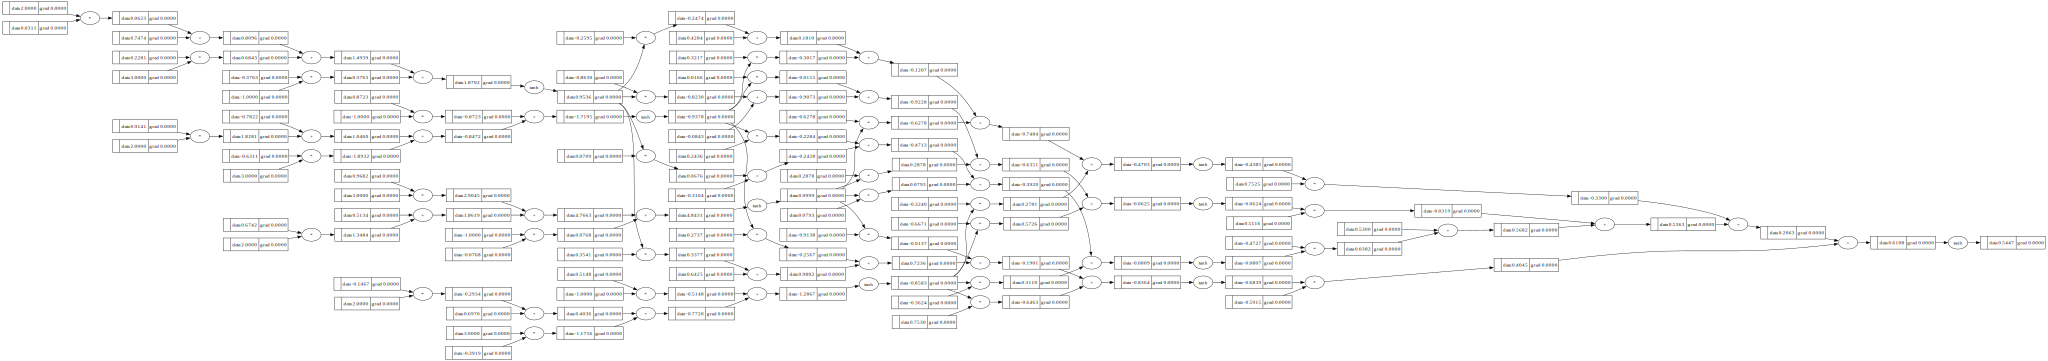

In [265]:
# Adding Neural Network Constructs
import random


class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        # we need to multiple all the elements of w with all the elements of x pair wise
        # using 'zip' to do this pairwise (x1, w1), (x2, w2) pairing
        # this is the same simple neuron from before, sum inputs, add constant (b), then squash
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

# Layer: a list of neurons
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # same as the below
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params


# Multilayer Perceptron: groups of layers connected together
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

# Example using MLP - 'x' gets passed all the way down to the neuron to help set x, weight, and offset
x = [2.0, 3.0,-1.0]
n = MLP(3, [4, 4, 1])
o = n(x)
draw_dot(o)

Matching our classes to the image:

Neuron: the white circles

Layer: the groups of circles

MLP: the entire graph

![](neural_net.jpeg)

In [ ]:
n.parameters()

In [270]:
# when given these inputs
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, -1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # we want to reach these targets
ypred = [n(x) for x in xs] # ypred is running through the MLP without adjustment
ypred


[(Value(data=4.085620730618907e-13)),
 (Value(data=4.085620730618907e-13)),
 (Value(data=4.085620730618907e-13)),
 (Value(data=4.085620730618907e-13))]

ypred is what the MLP outputs without adjustment. We get the following:


```python
[(Value(data=-0.39572274261119517)), # goal: 1.0
 (Value(data=0.08219542359138315)), # goal: -1.0
 (Value(data=-0.410536178130536)), # goal: -1.0
 (Value(data=-0.3018564710759744))] # goal: 1.0
```

loss: a single number representing the delta between the values we got and our targets.

the weights ('w') and the constant ('b') are the values we want to adjust to try and get closer to our target values

**Gradients are vectors pointing in the direction of increased loss**

By reading the gradiant, we know which way to bump `w` and `b`

In [144]:
# going to implement the mean^2 error loss
losses = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
# Loss should be without sign, the farther from 0 the worse the result
loss = sum(losses) # getting to a single number # 7ish...
# backward pass, calculate grads
loss.backward()

In [ ]:
# inspecting loss - what is loss at this point?
# it is the full expression of four forward passes of the MLP, the squaring and summing to get to our loss value
# it is a BIG diagram
draw_dot(loss)

In [ ]:
n.layers[0].neurons[0].w[0].grad # 3.5164
n.layers[0].neurons[0].w[0].data # -0.03173
# 

In [ ]:
# step 1: recalculate our loss value
ypred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred)) # mean^2 error loss calc to get to a single number
loss

In [257]:
# step 2: do back propogation after weight adjustments
loss.backward()

In [258]:
# step 3: update weights and 'b'
for p in n.parameters():
    p.data += -0.01 * p.grad # the negative in -0.01 keeps the sign correct for minimizing loss...(?)



In [269]:
# making this an actual loop
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # re-init grad before calculating! we do a +=
    for p in n.parameters():
        p.grad = 0.0
    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data = -0.1 * p.grad

    print(k, loss.data)


0 4.0
1 4.0
2 4.0
3 4.0
4 4.0
5 4.0
6 4.0
7 4.0
8 4.0
9 4.0
10 4.0
11 4.0
12 4.0
13 4.0
14 4.0
15 4.0
16 4.0
17 4.0
18 4.0
19 4.0
